In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve

In [2]:
# esthetic definitions for the plots
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'

In [3]:
# a function returning the three masses given the Delta m^2, the total mass, and the hierarchy (e.g. 'IN' or 'IH')
# taken from a piece of MontePython written by Thejs Brinckmann
def get_masses(delta_m_squared_atm, delta_m_squared_sol, sum_masses, hierarchy):
    # any string containing letter 'n' will be considered as refering to normal hierarchy
    if 'n' in hierarchy.lower():
        # Normal hierarchy massive neutrinos. Calculates the individual
        # neutrino masses from M_tot_NH and deletes M_tot_NH
        #delta_m_squared_atm=2.45e-3
        #delta_m_squared_sol=7.50e-5
        m1_func = lambda m1, M_tot, d_m_sq_atm, d_m_sq_sol: M_tot**2. + 0.5*d_m_sq_sol - d_m_sq_atm + m1**2. - 2.*M_tot*m1 - 2.*M_tot*(d_m_sq_sol+m1**2.)**0.5 + 2.*m1*(d_m_sq_sol+m1**2.)**0.5
        m1,opt_output,success,output_message = fsolve(m1_func,sum_masses/3.,(sum_masses,delta_m_squared_atm,delta_m_squared_sol),full_output=True)
        m1 = m1[0]
        m2 = (delta_m_squared_sol + m1**2.)**0.5
        m3 = (delta_m_squared_atm + 0.5*(m2**2. + m1**2.))**0.5
        return m1,m2,m3
    else:
        # Inverted hierarchy massive neutrinos. Calculates the individual
        # neutrino masses from M_tot_IH and deletes M_tot_IH
        #delta_m_squared_atm=-2.45e-3
        #delta_m_squared_sol=7.50e-5
        delta_m_squared_atm = -delta_m_squared_atm
        m1_func = lambda m1, M_tot, d_m_sq_atm, d_m_sq_sol: M_tot**2. + 0.5*d_m_sq_sol - d_m_sq_atm + m1**2. - 2.*M_tot*m1 - 2.*M_tot*(d_m_sq_sol+m1**2.)**0.5 + 2.*m1*(d_m_sq_sol+m1**2.)**0.5
        m1,opt_output,success,output_message = fsolve(m1_func,sum_masses/3.,(sum_masses,delta_m_squared_atm,delta_m_squared_sol),full_output=True)
        m1 = m1[0]
        m2 = (delta_m_squared_sol + m1**2.)**0.5
        m3 = (delta_m_squared_atm + 0.5*(m2**2. + m1**2.))**0.5
        return m1,m2,m3

In [4]:
# test of this function, returning the 3 masses for total mass of 0.1eV
m1,m2,m3 = get_masses(2.45e-3,7.50e-5,0.1,'NH')
print('NH:',m1,m2,m3,m1+m2+m3)
m1,m2,m3 = get_masses(2.45e-3,7.50e-5,0.1,'IH')
print('IH:',m1,m2,m3,m1+m2+m3)

NH: 0.02193372404432645 0.023581523497277785 0.05448475245839577 0.1
IH: 0.0491271470699318 0.04988463269615913 0.0009882202339095729 0.1000000000000005


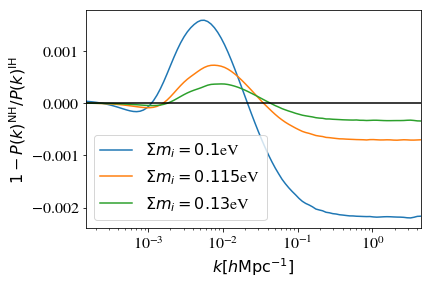

In [5]:
# The goal of this cell is to compute the ratio of P(k) for NH and IH with the same total mass
commonsettings = {'N_ur':0,
                  'N_ncdm':3,
                  'output':'mPk',
                  'P_k_max_1/Mpc':3.0,
                  # The next line should be uncommented fgor higher precision (but significantly slower running)
                  'ncdm_fluid_approximation':3,
                  # You may uncomment this line to get more info on the ncdm sector from Class:
                  'background_verbose':1
                 }

# array of k values in 1/Mpc
kvec = np.logspace(-4,np.log10(3),100)
# array for storing legend
legarray = []

# loop over total mass values
for sum_masses in [0.1, 0.115, 0.13]:
    # normal hierarchy
    [m1, m2, m3] = get_masses(2.45e-3,7.50e-5, sum_masses, 'NH')
    NH = Class()
    NH.set(commonsettings)
    NH.set({'m_ncdm':str(m1)+','+str(m2)+','+str(m3)})
    NH.compute()
    # inverted hierarchy
    [m1, m2, m3] = get_masses(2.45e-3,7.50e-5, sum_masses, 'IH')
    IH = Class()
    IH.set(commonsettings)
    IH.set({'m_ncdm':str(m1)+','+str(m2)+','+str(m3)})
    IH.compute()
    pkNH = []
    pkIH = []
    for k in kvec:
        pkNH.append(NH.pk(k,0.))
        pkIH.append(IH.pk(k,0.))
    NH.struct_cleanup()
    IH.struct_cleanup()
    # extract h value to convert k from 1/Mpc to h/Mpc
    h = NH.h()
    plt.semilogx(kvec/h,1-np.array(pkNH)/np.array(pkIH))
    legarray.append(r'$\Sigma m_i = '+str(sum_masses)+'$eV')
plt.axhline(0,color='k')
plt.xlim(kvec[0]/h,kvec[-1]/h)
plt.xlabel(r'$k [h \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$1-P(k)^\mathrm{NH}/P(k)^\mathrm{IH}$')
plt.legend(legarray)    

In [ ]:
plt.savefig('neutrinohierarchy.pdf')